<a href="https://colab.research.google.com/github/pacesatuinineh/Sift-Features/blob/main/K1Resnet_wajahSorongRaya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install efficientnet==0.0.3

In [2]:
import cv2
import numpy as np
import os
import pandas as pd
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications import EfficientNetB5
#from tensorflow.keras.applications import VGG16
#from tensorflow.keras.applications import InceptionV3
#from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [4]:
# Paths
#data_path = "/content/drive/MyDrive/wajahPBD"  # Adjust the path to where 'papua-1' and 'papua-2' are located



In [5]:
import os

def list_folders_and_image_count(data_path):
  """
  Lists subfolders within a directory and counts the number of images in each.

  Args:
    data_path: The path to the main directory.

  Returns:
    A dictionary where keys are folder names and values are image counts.
  """
  folder_info = {}
  for folder_name in os.listdir(data_path):
    folder_path = os.path.join(data_path, folder_name)
    if os.path.isdir(folder_path):
      image_count = 0
      for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
          image_count += 1
      folder_info[folder_name] = image_count
  return folder_info

# Example usage:
data_path = "/content/drive/MyDrive/WajahSorongRaya"
folder_data = list_folders_and_image_count(data_path)

# Print the results:
for folder, count in folder_data.items():
  print(f"Folder: {folder}, Image Count: {count}")

Folder: SorongSelatan, Image Count: 320
Folder: Moi2, Image Count: 364
Folder: Raja Ampat, Image Count: 337
Folder: Maybrat, Image Count: 355


In [6]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 100

In [7]:
# Preprocessing Function
def preprocess_image(image):
    # Resize image
    image = cv2.resize(image, IMAGE_SIZE)
    # Histogram equalization
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    # Apply noise reduction
    image = cv2.fastNlMeansDenoising(image, h=10)
    # Convert back to RGB
    return cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

In [8]:
def apply_haar_wavelet_and_gaussian(image):
    coeffs2 = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs2
    LL_gaussian = cv2.GaussianBlur(LL, (5, 5), 0)  # Apply Gaussian filter
    return LL_gaussian  # Use the low-frequency component with Gaussian filter

In [9]:
# Function to apply Haar wavelet transformation
def apply_haar_wavelet(image):
    I = image.astype(float)
    m, n = I.shape[:2]
    if m % 2 != 0:
        m -= 1
    if n % 2 != 0:
        n -= 1
    I = I[:m, :n]

    LL = np.zeros((m // 2, n // 2))
    for i in range(0, m, 2):
        for j in range(0, n, 2):
            Ixy = I[i:i + 2, j:j + 2]
            LL[i // 2, j // 2] = np.mean(Ixy)
    return LL

In [10]:
# Function to extract HOG features
def extract_hog_features(image):
    if len(image.shape) == 3:
        image = rgb2gray(image)
    features, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    return features

In [11]:
def load_data(path):
    data = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    # Preprocess image
                    image = preprocess_image(image)

                    # Apply Haar wavelet
                    #haar_image = apply_haar_wavelet(image)

                    # Resize the image to 224x224 for ResNet50
                    #haar_image = cv2.resize(haar_image, (224, 224))

                    # Extract HOG features
                    #hog_features = extract_hog_features(image)

                    # Extract Gabor features
                    #gabor_features = extract_gabor_features(image)

                    #Extract Haar + Gaussia
                    #haar_image = apply_haar_wavelet_and_gaussian(image)

                    #Extract Haar + Gabor
                    #combined_features = np.concatenate([haar_image.flatten(), gabor_features])

                    data.append(image)  # Append the processed image

                    #data.append(combined_features)  # Append the processed image

                    labels.append(folder)

    return np.array(data), np.array(labels)

In [12]:
# Load dataset
data, labels = load_data(data_path)

In [13]:
num_images_to_display = 5  # Jumlah gambar yang ingin ditampilkan
sample_images = data[:num_images_to_display]
sample_labels = labels[:num_images_to_display]

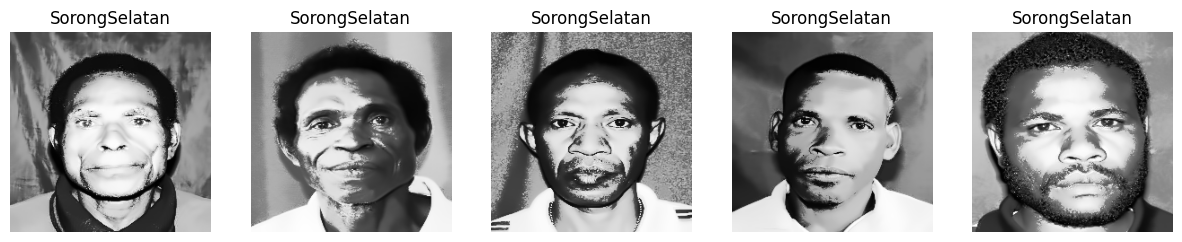

In [14]:
fig, axes = plt.subplots(1, num_images_to_display, figsize=(15, 5))  # Sesuaikan figsize jika perlu
for i, (image, label) in enumerate(zip(sample_images, sample_labels)):
    axes[i].imshow(image.astype(np.uint8), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(label)  # Menampilkan label sebagai judul di bawah gambar
plt.show()

In [15]:
# Encode labels
encoder = LabelEncoder()
labels_encoded = encoder.fit_transform(labels)


In [16]:
# Split into training and testing
from sklearn.model_selection import train_test_split
#train_data, test_data, train_labels, test_labels = train_test_split(data, labels_encoded, test_size=0.2, random_state=42)
train_images, test_images, train_labels, test_labels = train_test_split(
    data, labels_encoded, test_size=0.2, random_state=42
)

# Split training data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.2, random_state=42
)

# Print the number of samples in each set
print("Jumlah data train:", len(train_images))
print("Jumlah data validasi:", len(val_images))
print("Jumlah data test:", len(test_images))



Jumlah data train: 880
Jumlah data validasi: 220
Jumlah data test: 276


In [17]:
# Class weights
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weight_dict = dict(enumerate(class_weights))


In [18]:
# Define CNN model with pretrained ResNet50
def build_model():
    input_tensor = Input(shape=(224, 224, 3))
    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
    #base_model = EfficientNetB5(weights='imagenet', include_top=False, input_tensor=input_tensor)  # Ganti ResNet50 dengan EfficientNetB
    #base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)
    #base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
    #base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)  # Tambahan lapisan
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = Dropout(0.5)(x)
    #x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    #x = Dropout(0.5)(x)
    predictions = Dense(len(encoder.classes_), activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Unfreeze the top layers of the model
    for layer in base_model.layers[-50:]:
        layer.trainable = True

    # Compile model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.7, 1.3],
    fill_mode='nearest'
)

In [20]:
test_datagen = ImageDataGenerator()

In [21]:
# Load and preprocess images for CNN
def load_and_preprocess_images(path):
    images = []
    labels = []
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if os.path.isdir(folder_path):
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file)
                image = cv2.imread(file_path)
                if image is not None:
                    image = preprocess_image(image)
                    images.append(image)
                    labels.append(folder)
    return np.array(images), np.array(labels)


In [22]:
#train_images, train_labels = load_and_preprocess_images(data_path)
#test_images, test_labels = load_and_preprocess_images(data_path)


# Print the number of samples in each set
#print("Jumlah data train:", len(train_images))
#print("Jumlah data validasi:", len(val_images))
#print("Jumlah data test:", len(test_images))





In [23]:
# Load and preprocess all images first
all_images, all_labels = load_and_preprocess_images(data_path)

# Split into training and testing, maintaining 20% for testing
train_images, test_images, train_labels, test_labels = train_test_split(
    all_images, all_labels, test_size=0.2, random_state=42
)

# Print the number of samples in each set
print("Jumlah data train:", len(train_images))
print("Jumlah data validasi:", len(val_images))  # val_images remains unchanged
print("Jumlah data test:", len(test_images))

Jumlah data train: 1100
Jumlah data validasi: 220
Jumlah data test: 276


In [24]:
# Encode labels
train_labels_encoded = encoder.fit_transform(train_labels)
test_labels_encoded = encoder.transform(test_labels)

train_labels_categorical = to_categorical(train_labels_encoded)
test_labels_categorical = to_categorical(test_labels_encoded)

# Callbacks
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-5)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [25]:
# Fit the model
history = model.fit(
    train_datagen.flow(train_images, train_labels_categorical, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=test_datagen.flow(test_images, test_labels_categorical, batch_size=BATCH_SIZE),
    callbacks=[reduce_lr, early_stopping],
    class_weight=class_weight_dict
)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


35/35 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.3464 - loss: 13.6262 - val_accuracy: 0.6739 - val_loss: 12.1275 - learning_rate: 1.0000e-04
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 342ms/step - accuracy: 0.5828 - loss: 12.4967 - val_accuracy: 0.7428 - val_loss: 11.8664 - learning_rate: 1.0000e-04
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 341ms/step - accuracy: 0.7103 - loss: 11.9626 - val_accuracy: 0.7391 - val_loss: 11.6645 - learning_rate: 1.0000e-04
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 343ms/step - accuracy: 0.7219 - loss: 11.8047 - val_accuracy: 0.7391 - val_loss: 11.5213 - learning_rate: 1.0000e-04
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - accuracy: 0.7243 - loss: 11.5856 - val_accuracy: 0.7138 - val_loss: 11.3754 - learning_rate: 1.0000e-04
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 347ms/step - accuracy: 0.7605 - loss: 11.2875 - val_accuracy: 0.7717 - val_loss: 11.1239 - learning_rate: 1.0000e-04
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 15s 348ms/step 

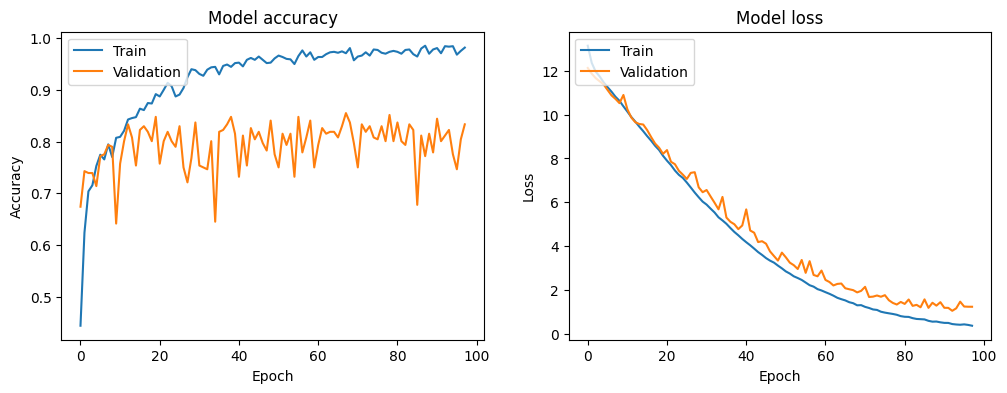

In [26]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')

plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 7s 472ms/step
               precision    recall  f1-score   support

      Maybrat       0.72      0.78      0.75        74
         Moi2       0.87      0.99      0.93        77
   Raja Ampat       0.98      0.78      0.87        64
SorongSelatan       0.70      0.66      0.68        61

     accuracy                           0.81       276
    macro avg       0.82      0.80      0.81       276
 weighted avg       0.82      0.81      0.81       276



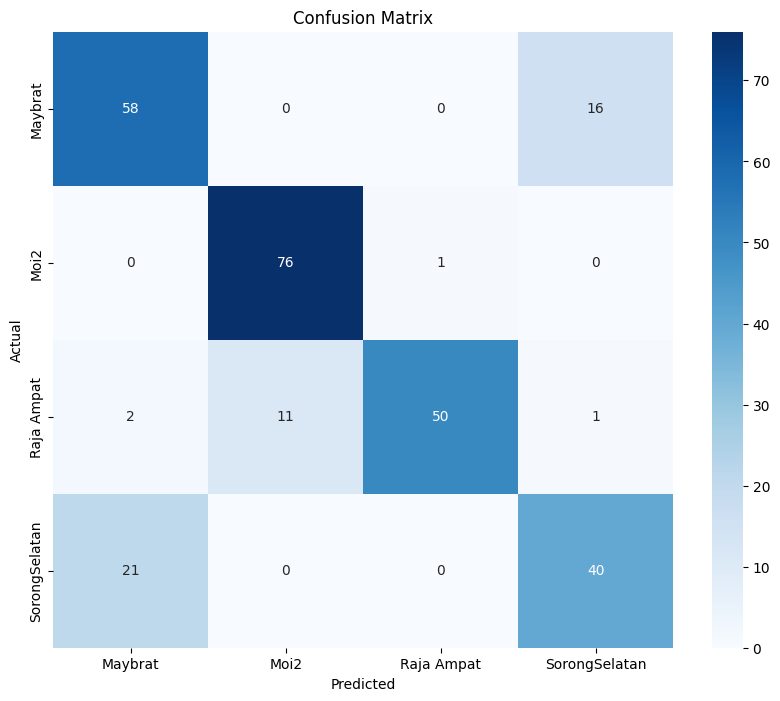

In [27]:
# Evaluate model
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Classification report and confusion matrix
print(classification_report(test_labels_encoded, predicted_classes, target_names=encoder.classes_))
cm = confusion_matrix(test_labels_encoded, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()